# Practice for Image Processing Logic
Using references from previous data wrangling labs and inclass1 to develop our functions for image processing.

In [2]:
#imports
#importing os to deal with file system
import os

#imports for data wrangling
import numpy as np
import pandas as pd

#imports to allow us to work with our images in matplot lib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#importing open CV
try:
    import cv2
except:
    !pip install opencv-python
    import cv2

#import Pillow
try:
    from PIL import Image, ImageFilter
except:
    !pip install opencv-python
    from PIL import Image, ImageFilter


# Thresholding
Following the guide from InClass1, 


in_image (720, 1280, 3) uint8 0 255


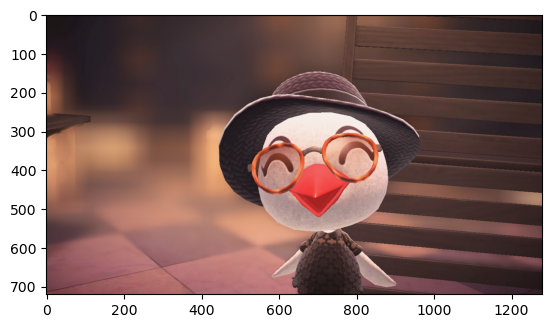

In [3]:
#input image
in_img = cv2.imread("test1.png")

in_img = in_img[:,:,::-1]
print('in_image', in_img.shape, in_img.dtype, in_img.min(), in_img.max())

plt.figure()
plt.imshow(in_img)


grayscaleImg [[21 21 21 ... 34 34 34]
 [21 21 21 ... 34 34 35]
 [21 21 21 ... 34 34 34]
 ...
 [71 71 72 ... 35 35 35]
 [74 75 75 ... 36 36 36]
 [74 75 76 ... 36 36 36]] (720, 1280) uint8 6 251


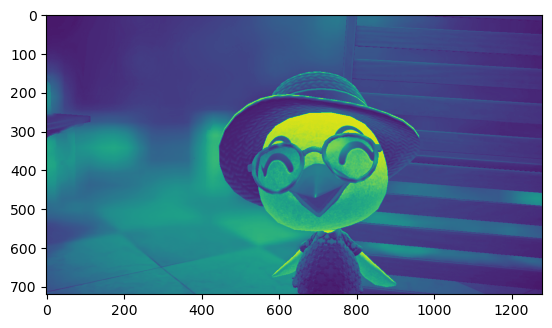

In [6]:
#converting our original test image into a grayscale image
grayImg = cv2.cvtColor(in_img, cv2.COLOR_BGR2GRAY)
#display our grayscale image
print('grayscaleImg', grayImg, grayImg.shape, grayImg.dtype, grayImg.min(), grayImg.max())

plt.figure()
plt.imshow(grayImg)

# Edge Detection


Documentation: 
OpenCV - Canny Edge Detection Documentation:
- https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html


# Contour Extraction

Helpful Resources:
- https://pyimagesearch.com/2021/05/12/adaptive-thresholding-with-opencv-cv2-adaptivethreshold/
- https://pillow.readthedocs.io/en/stable/handbook/concepts.html#coordinate-system
- 